# Video inference of our object detection pipeline

First we test the object detection pipeline on a standard image

# Select a model for inference

In [46]:
import tensorflow as tf
import larq as lq

# import custom modules
from utils.processing_tools import *
from utils.generators import *
from utils.model_tools import *


import pyximport
pyximport.install(reload_support=True)
from utils.evaluate import *


In [9]:
import infer

We will use the arguments from the inference file

In [10]:
args =  ['--architecture', 'resnet50_centernet', '--gpu', '5', '--dataset-path', '../../datasets/PascalVOC/', '--model-weights-path', 'saved_models/resnet50_centernet/resnet50_centernet_model.h5']
# on the inference script we use: args = sys.argv[1:]
args = infer.parse_args(args)

{'architecture': 'resnet50_centernet', 'batch_size': 32, 'num_classes': 20, 'input_size': 512, 'gpu': '5', 'model_summary': True, 'dataset_path': '../../datasets/PascalVOC/', 'model_weights_path': 'saved_models/resnet50_centernet/resnet50_centernet_model.h5'}


Now we get the parsed args

In [11]:
num_classes = args.num_classes
input_size = (args.input_size,args.input_size)
#assert input_size[0] == input_size[1], "Input shape must be the same"
batch_size = args.batch_size
# optionally choose specific GPU
if args.gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
# CHECK GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print('problem loading gpu')
import importlib
sys.path.append('architectures')
#import architecture module
architecture_module = importlib.import_module(args.architecture)

# set architecture name
architecture_name = args.architecture

Default GPU Device: /device:GPU:0


Instantiate a model and download weights

In [12]:
# create model given an architecture
# (the centernet input must be specified by the architecture file)
model, prediction_model, debug_model = architecture_module.centernet(input_size = input_size, num_classes = num_classes)

try:
    model.load_weights(args.model_weights_path)
    print("Model loaded!")
except:
    print("Error: Failed loading model from weights...")
    #sys.exit(1)

# compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss={'centernet_loss': lambda y_true, y_pred: y_pred})

if args.model_summary:
    lq.models.summary(model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model loaded!
+model_3 stats-------------------------------------------------------------------------------+
| Layer                   Input prec.              Outputs  # 32-bit     Memory  32-bit MACs |
|                               (bit)                            x 1       (kB)              |
+--------------------------------------------------------------------------------------------+
| inpu

Open the validation dataset and instantiate a generator

In [13]:
validation_generator = PascalVocGenerator(
    args.dataset_path,
    # val of PascalVOC is the test of VOC2007
    'val',
    skip_difficult=True,
    shuffle_groups=False,
    input_size = input_size[0],
    batch_size = batch_size
)

Benchmark the model on images from the validation dataset

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Inference time :  4.0106964111328125


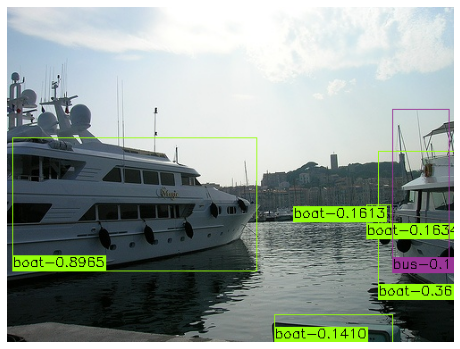

In [14]:
# inference on test dataset for 40 images
initial_img  = 500
for i in range(1):
    dataset_img_inference(initial_img + i, validation_generator, prediction_model, score_threshold = 0.01, num_classes = 20, figsize=(8,8))

Benchmark the model on the whole validation dataset

In [ ]:
average_precisions = evaluate(validation_generator, prediction_model,
                          flip_test=False,
                          keep_resolution=False,
                          score_threshold=0.01)
# compute per class average precision
total_instances = []
precisions = []
for label, (average_precision, num_annotations) in average_precisions.items():
    print('{:.0f} instances of class'.format(num_annotations), validation_generator.label_to_name(label),
        'with average precision: {:.4f}'.format(average_precision))
    total_instances.append(num_annotations)
    precisions.append(average_precision)
mean_ap = sum(precisions) / sum(x > 0 for x in total_instances)
print('mAP: {:.4f}'.format(mean_ap))

# Video Inference Function

In [15]:
# inference image
def img_inference(image, pred_model, num_classes, score_threshold = 0.1, 
                    save_img = False, plot_img = True, figsize = (15,15), infer_time = True):
    
    colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]

    classes = list(img_generator.classes.keys())
    # create directory if it doesn't exist
    if save_img:
        if not os.path.isdir('tests'):
            os.mkdir('tests')
            
    # preprocess image     
    src_image = image.copy()
    
    c = np.array([image.shape[1] / 2., image.shape[0] / 2.], dtype=np.float32)
    s = max(image.shape[0], image.shape[1]) * 1.0

    tgt_w = img_generator.input_size
    tgt_h = img_generator.input_size
    image = img_generator.preprocess_image(image, c, s, tgt_w=tgt_w, tgt_h=tgt_h)

    inputs = np.expand_dims(image, axis=0)
    
    # run network
    start = time.time()
    detections = pred_model.predict_on_batch(inputs)[0]
    delta_t = time.time() - start
    
    if infer_time:
        print('Inference time : ', delta_t)
    
    # get scores
    scores = detections[:, 4]


    # select indices which have a score above the threshold
    indices = np.where(scores > score_threshold)[0]

    # select those detections
    detections = detections[indices]
    detections_copy = detections.copy()
    detections = detections.astype(np.float64)
    trans = get_affine_transform(c, s, (tgt_w // 4, tgt_h // 4), inv=1)

    for j in range(detections.shape[0]):
        detections[j, 0:2] = affine_transform(detections[j, 0:2], trans)
        detections[j, 2:4] = affine_transform(detections[j, 2:4], trans)

    detections[:, [0, 2]] = np.clip(detections[:, [0, 2]], 0, src_image.shape[1])
    detections[:, [1, 3]] = np.clip(detections[:, [1, 3]], 0, src_image.shape[0])
    for detection in detections:
        xmin = int(round(detection[0]))
        ymin = int(round(detection[1]))
        xmax = int(round(detection[2]))
        ymax = int(round(detection[3]))
        score = '{:.4f}'.format(detection[4])
        class_id = int(detection[5])
        color = colors[class_id]
        class_name = classes[class_id]
        label = '-'.join([class_name, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    if save_img:
        image_fname = img_generator.image_names[idx]
        cv2.imwrite('tests/{}.jpg'.format(image_fname), src_image)
    if plot_img:
        src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=figsize)
        plt.imshow(src_image)
        plt.axis('off')
        plt.show()

In [16]:
#############################################################
#
#    Image inference function
#
#############################################################

voc_classes = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

def preprocess_image(image, c, s, tgt_w, tgt_h):
        trans_input = get_affine_transform(c, s, (tgt_w, tgt_h))
        image = cv2.warpAffine(image, trans_input, (tgt_w, tgt_h), flags=cv2.INTER_LINEAR)
        image = image.astype(np.float32)

        image[..., 0] -= 103.939
        image[..., 1] -= 116.779
        image[..., 2] -= 123.68

        return image

# inference directly from an image stored in RAM
def image_direct_inference(image, pred_model, num_classes, colors, score_threshold = 0.1, 
                           output_name = 'image_output',
                    save_img = False, plot_img = False, figsize = (15,15), infer_time = False,
                    classes = voc_classes, input_w = 512, input_h = 512, ):
    
    tgt_w=input_w
    tgt_h=input_h
    

    classes = list(classes.keys())
    # create directory if it doesn't exist
    if save_img:
        if not os.path.isdir('output'):
            os.mkdir('output')
                
    src_image = image.copy()
    
    c = np.array([image.shape[1] / 2., image.shape[0] / 2.], dtype=np.float32)
    s = max(image.shape[0], image.shape[1]) * 1.0

    image = preprocess_image(image, c, s, tgt_w=tgt_w, tgt_h=tgt_h)

    inputs = np.expand_dims(image, axis=0)
    
    # run network
    start = time.time()
    detections = pred_model.predict_on_batch(inputs)[0]
    delta_t = time.time() - start
    
    if infer_time:
        print('Inference time : ', delta_t)
    
    # get scores
    scores = detections[:, 4]


    # select indices which have a score above the threshold
    indices = np.where(scores > score_threshold)[0]

    # select those detections
    detections = detections[indices]
    detections_copy = detections.copy()
    detections = detections.astype(np.float64)
    trans = get_affine_transform(c, s, (tgt_w // 4, tgt_h // 4), inv=1)

    for j in range(detections.shape[0]):
        detections[j, 0:2] = affine_transform(detections[j, 0:2], trans)
        detections[j, 2:4] = affine_transform(detections[j, 2:4], trans)

    detections[:, [0, 2]] = np.clip(detections[:, [0, 2]], 0, src_image.shape[1])
    detections[:, [1, 3]] = np.clip(detections[:, [1, 3]], 0, src_image.shape[0])
    for detection in detections:
        xmin = int(round(detection[0]))
        ymin = int(round(detection[1]))
        xmax = int(round(detection[2]))
        ymax = int(round(detection[3]))
        score = '{:.4f}'.format(detection[4])
        class_id = int(detection[5])
        color = colors[class_id]
        class_name = classes[class_id]
        label = '-'.join([class_name, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    if save_img:
        cv2.imwrite(os.path.join('output',output_name), src_image)
    if plot_img:
        src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=figsize)
        plt.imshow(src_image)
        plt.axis('off')
        plt.show()
        
    return detections

In [31]:
colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]
colors

[[231, 6, 47],
 [121, 114, 122],
 [61, 221, 46],
 [54, 56, 73],
 [4, 125, 24],
 [127, 168, 207],
 [164, 83, 136],
 [123, 186, 87],
 [210, 176, 240],
 [236, 10, 173],
 [190, 225, 101],
 [89, 203, 179],
 [245, 18, 91],
 [132, 203, 113],
 [226, 215, 194],
 [179, 119, 206],
 [64, 68, 129],
 [247, 118, 218],
 [44, 242, 116],
 [9, 171, 186]]

# Test with sample video footage

ref: https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

## Get .mp4 files

In [18]:
video_path = os.path.join('..','..','datasets','NokiaVillarceauxVideoFeed')
video_path

'../../datasets/NokiaVillarceauxVideoFeed'

In [19]:
!ls '../../datasets/NokiaVillarceauxVideoFeed'

BOU  GAL  GAL-EXT-NORD-OUEST_2022-06-01_08h44min22s120ms.mp4


In [20]:
filenames = []
dirnames = []
for (_dirpath, _dirnames, _filenames) in os.walk(video_path):
    filenames.extend(_filenames)
    dirnames.extend(_dirnames)
    break

In [21]:
dirnames

['GAL', 'BOU']

In [22]:
filenames

['GAL-EXT-NORD-OUEST_2022-06-01_08h44min22s120ms.mp4']

In [23]:
filepath = os.path.join(video_path, filenames[0])
filepath

'../../datasets/NokiaVillarceauxVideoFeed/GAL-EXT-NORD-OUEST_2022-06-01_08h44min22s120ms.mp4'

## Processing footage

In [24]:
import numpy as np
import cv2 
import os

In [27]:
# for the moment extracts 1 fps
def extractImages(pathIn, pathOut = None, max_it = 5, figsize = (15,15), verbose = True):
    if pathOut is None:
        count = 0
        vidcap = cv2.VideoCapture(pathIn)
        success,image = vidcap.read()
        success = True
        while success:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))    # added this line 
            success,image = vidcap.read()
            if verbose:
                print ('Read a new frame: ', success)
            src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=figsize)
            plt.imshow(src_image)
            plt.axis('off')
            plt.show()
            count = count + 1
            if count == max_it:
                break
    else:
        count = 0
        vidcap = cv2.VideoCapture(pathIn)
        success,image = vidcap.read()
        success = True
        while success:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))    # added this line 
            success,image = vidcap.read()
            if verbose:
                print ('Read a new frame: ', success)
            cv2.imwrite( pathOut + "\\frame%d.jpg" % count, image)     # save frame as JPEG file
            count = count + 1

Read a new frame:  True


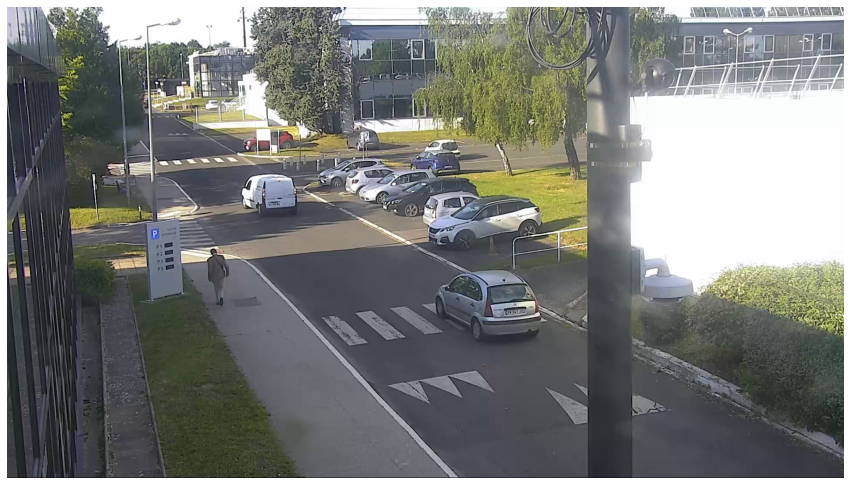

Read a new frame:  True


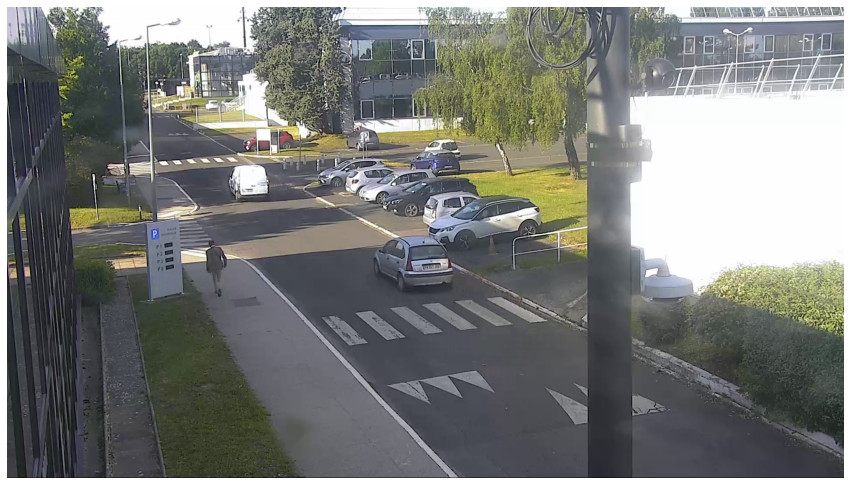

In [55]:
extractImages(filepath,max_it = 2)

## Object detection on video feed

In [110]:
# for the moment extracts 1 fps
def video_od(pred_model, num_classes, pathIn, pathOut = None, max_it = 10, figsize = (15,15), verbose = True):
    if pathOut is None:
        count = 0
        vidcap = cv2.VideoCapture(pathIn)
        success,image = vidcap.read()
        success = True
        while success:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))    # added this line 
            success,image = vidcap.read()
            if verbose:
                print ('Read a new frame: ', success)
            #src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_direct_inference(image, pred_model, num_classes, _colors, )
            count = count + 1
            if count == max_it:
                break

In [111]:
video_od(prediction_model, num_classes, filepath)

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True


In [88]:
480*2

960

## Generating Video Predictions

In [148]:
def generate_video_od(pred_model, num_classes, pathIn, colors, out_name,
                      classes = voc_classes, out_dim = (1024,576), max_it = 1e5, 
                      figsize = (15,15), verbose = False):
    """Output video of Object detection pipeline.

    Keyword arguments:
    max_it -- max number of iterations performed
    out_name -- name of the output file 
    """
    # Get class names in string format
    classes = list(classes.keys())
    
    # create directory if it doesn't exist
    if not os.path.isdir('output'):
        os.mkdir('output')
    
    # Open and process video using cv2
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    
    # Convert the resolutions from float to integer.
    frame_width = int(vidcap.get(3))
    frame_height = int(vidcap.get(4))

    property_id = int(cv2.CAP_PROP_FRAME_COUNT) 
    video_fps = vidcap.get(cv2.CAP_PROP_FPS)

    # Process subset or whole video
    nframes = int(cv2.VideoCapture.get(vidcap, property_id))
    nprocess = min(nframes, max_it)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    
    # Select output format
    out = cv2.VideoWriter(os.path.join('output', out_name + '.mp4'), fourcc, video_fps, out_dim)
    
    
    if verbose:
        print("Video framerate is {}".format(video_fps))
        print("Video length consists of {} frames\n".format(nframes))
        if nprocess != nframes:
            print("Processing  {} frames\n\n".format(nprocess))
        
    
    count = 0
    while success and count < nprocess:
        
        success,image = vidcap.read(count)
        
        try:
            detections = image_direct_inference(image, pred_model, num_classes, colors, plot_img = False, infer_time = False)
        except:
            detections = []
        #add bbox to frames
        for detection in detections:
            xmin = int(round(detection[0]))
            ymin = int(round(detection[1]))
            xmax = int(round(detection[2]))
            ymax = int(round(detection[3]))
            score = '{:.4f}'.format(detection[4])
            class_id = int(detection[5])
            color = colors[class_id]
            class_name = classes[class_id]
            label = '-'.join([class_name, score])
            ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1)
            cv2.rectangle(image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
            cv2.putText(image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        
        
        # write the OD frame
        out.write(cv2.resize(image, out_dim, interpolation = cv2.INTER_AREA))
        
        count = count + 1
        if verbose:
            pct = (count/nprocess)*100
            if pct%10 == 0:
                print("Processed {}% of frames".format(pct))

    # When everything done, release the video capture and video write objects
    vidcap.release()
    out.release()
    
    

In [149]:
generate_video_od(prediction_model, num_classes, filepath, colors, out_name = 'video_out_35', max_it = 5, verbose = True)

Video framerate is 14.972115343046129
Video length consists of 17316 frames

Processing  5 frames


(1080, 1920, 3)
Processed 20.0% of frames
(1080, 1920, 3)
Processed 40.0% of frames
(1080, 1920, 3)
Processed 60.0% of frames
(1080, 1920, 3)
Processed 80.0% of frames
(1080, 1920, 3)
Processed 100.0% of frames


In [47]:
#process other videos

In [61]:
!ls

architectures  infer.py    output	requirements.yml  utils
augmentor      INSTALL.md  __pycache__	saved_models	  video-inference.ipynb
datasets       model_log   README.md	train.py


In [108]:
!ls 'output'

video_out_101.mp4  video_out_25.mp4  video_out_5.mp4  video_output.mp4
video_out_10.mp4   video_out_35.mp4  video_out_7.mp4
video_out_15.mp4   video_out_5.avi   video_out.mp4


## Heatmaps 

In [120]:
# inference directly from an image stored in RAM
def hmap_direct_inference(image, debug_model, num_classes, score_threshold = 0.1, 
                           output_name = 'image_output',
                    save_img = False, plot_img = False, figsize = (15,15), infer_time = False,
                    classes = voc_classes, input_w = 512, input_h = 512 ):
    
    tgt_w=input_w
    tgt_h=input_h
    
    colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]

    classes = list(classes.keys())
    # create directory if it doesn't exist
    if save_img:
        if not os.path.isdir('output'):
            os.mkdir('output')
                
    src_image = image.copy()
    
    c = np.array([image.shape[1] / 2., image.shape[0] / 2.], dtype=np.float32)
    s = max(image.shape[0], image.shape[1]) * 1.0

    image = preprocess_image(image, c, s, tgt_w=tgt_w, tgt_h=tgt_h)

    inputs = np.expand_dims(image, axis=0)
    
    # run network
    start = time.time()
    heatmaps = heatmaps = debug_model.predict_on_batch(inputs)[0][0]
    delta_t = time.time() - start
    
    
    if save_img:
        cv2.imwrite(os.path.join('output',output_name), src_image)
    if plot_img:
        plt.figure(figsize=figsize)
        for idx in range(0,20):
            plt.subplot(4, 5, idx+1)
            plt.imshow(heatmaps[:,:,idx])
            title = 'class: ' + classes[idx]
            plt.title(title)
        
    return heatmaps

In [134]:
voc_classes

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [132]:
# for the moment extracts 1 fps
def video_hmaps(pred_model, num_classes, pathIn, classes_displayed = [6], pathOut = None, max_it = 5, figsize = (15,15), verbose = True):
    if pathOut is None:
        count = 0
        vidcap = cv2.VideoCapture(pathIn)
        success,image = vidcap.read()
        success = True
        while success:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))    # added this line 
            success,image = vidcap.read()
            if verbose:
                print ('Read a new frame: ', success)
            #src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            hm = hmap_direct_inference(image, debug_model, num_classes, plot_img = False)
            count = count + 1
            plt.imshow(hm[:,:,classes_displayed[0]])
            plt.show()
            if count == max_it:
                break
            
            

Read a new frame:  True


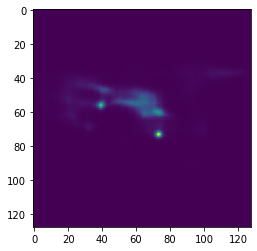

Read a new frame:  True


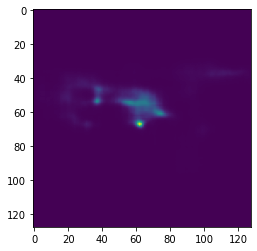

Read a new frame:  True


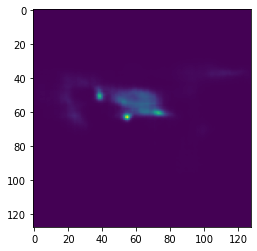

Read a new frame:  True


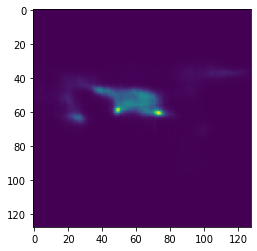

Read a new frame:  True


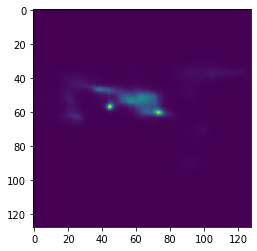

In [133]:
video_hmaps(prediction_model, num_classes, filepath)

In [224]:
def generate_video_hm(pred_model, num_classes, pathIn, colors, out_name,
                      classes = voc_classes, display_class = 6, out_dim = (1024,576), max_it = 1e5, 
                      figsize = (15,15), verbose = False):
    """Output video of Object detection pipeline.

    Keyword arguments:
    max_it -- max number of iterations performed
    out_name -- name of the output file 
    """
    # Get class names in string format
    classes = list(classes.keys())
    
    # create directory if it doesn't exist
    if not os.path.isdir('output'):
        os.mkdir('output')
    
    # Open and process video using cv2
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    
    # Convert the resolutions from float to integer.
    frame_width = int(vidcap.get(3))
    frame_height = int(vidcap.get(4))

    property_id = int(cv2.CAP_PROP_FRAME_COUNT) 
    video_fps = vidcap.get(cv2.CAP_PROP_FPS)

    # Process subset or whole video
    nframes = int(cv2.VideoCapture.get(vidcap, property_id))
    nprocess = min(nframes, max_it)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    
    # Select output format
    out = cv2.VideoWriter(os.path.join('output', out_name + '.mp4'), fourcc, video_fps, out_dim)
    
    
    if verbose:
        print("Video framerate is {}".format(video_fps))
        print("Video length consists of {} frames\n".format(nframes))
        if nprocess != nframes:
            print("Processing  {} frames\n\n".format(nprocess))
        
    
    count = 0
    while success and count < nprocess:
        
        success,image = vidcap.read(count)
        
        hm = hmap_direct_inference(image, debug_model, num_classes, plot_img = False)
        
        # add other heatmaps
        heatmap = hm[:,:,display_class]
        
        heatmap = (heatmap * 255).astype(np.uint8)
        image = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
        
        
        # write the OD frame
        out.write(cv2.resize(image, out_dim, interpolation = cv2.INTER_AREA))
        
        count = count + 1
        if verbose:
            pct = (count/nprocess)*100
            if pct%10 == 0:
                print("Processed {}% of frames".format(pct))

    # When everything done, release the video capture and video write objects
    vidcap.release()
    out.release()

# Generate predictions

In [226]:
generate_video_hm(prediction_model, num_classes, filepath, colors, out_name = '500_frames_video_OD', max_it = 500, verbose = True)

Video framerate is 14.972115343046129
Video length consists of 17316 frames

Processing  500 frames


Processed 10.0% of frames
Processed 20.0% of frames
Processed 30.0% of frames
Processed 40.0% of frames
Processed 50.0% of frames
Processed 60.0% of frames
Processed 70.0% of frames
Processed 80.0% of frames
Processed 90.0% of frames
Processed 100.0% of frames


In [229]:
generate_video_hm(prediction_model, num_classes, filepath, colors, display_class = 14, out_name = '500_frames_video_OD', max_it = 500, verbose = True)

Video framerate is 14.972115343046129
Video length consists of 17316 frames

Processing  500 frames


Processed 10.0% of frames
Processed 20.0% of frames
Processed 30.0% of frames
Processed 40.0% of frames
Processed 50.0% of frames
Processed 60.0% of frames
Processed 70.0% of frames
Processed 80.0% of frames
Processed 90.0% of frames
Processed 100.0% of frames


In [227]:
generate_video_od(prediction_model, num_classes, filepath, colors, out_name = '500_frames_video_HM', max_it = 500, verbose = True)

Video framerate is 14.972115343046129
Video length consists of 17316 frames

Processing  500 frames


(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
Processed 10.0% of frames
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1

(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
Processed 100.0% of frames
